统计结果:
{'总胜率': np.float64(0.5793237971391417), '总赔率': np.float64(2.948654521152552), '总天数': 99, '日均频率': np.float64(15.535353535353535)}


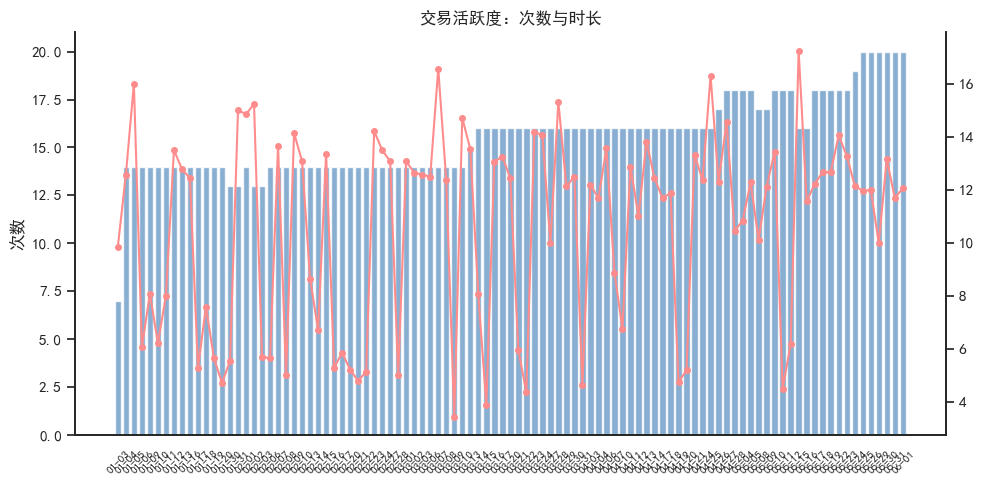

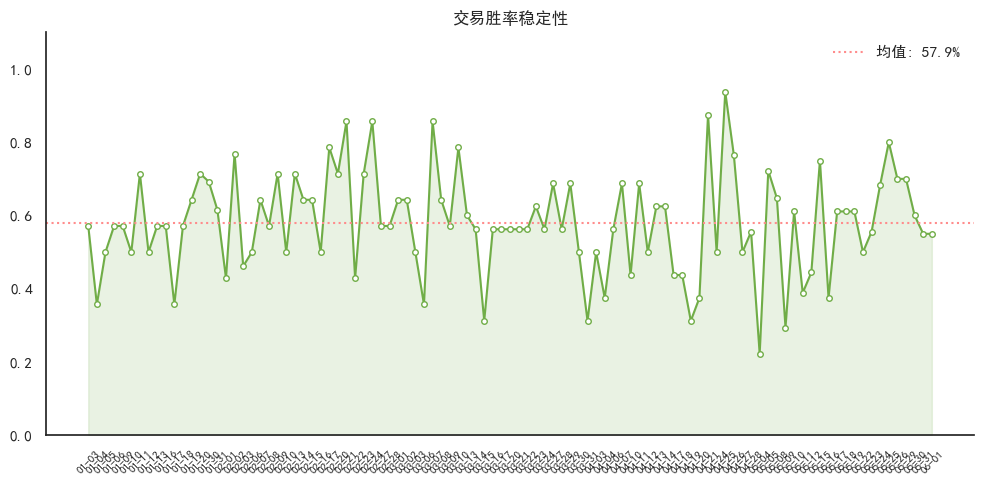

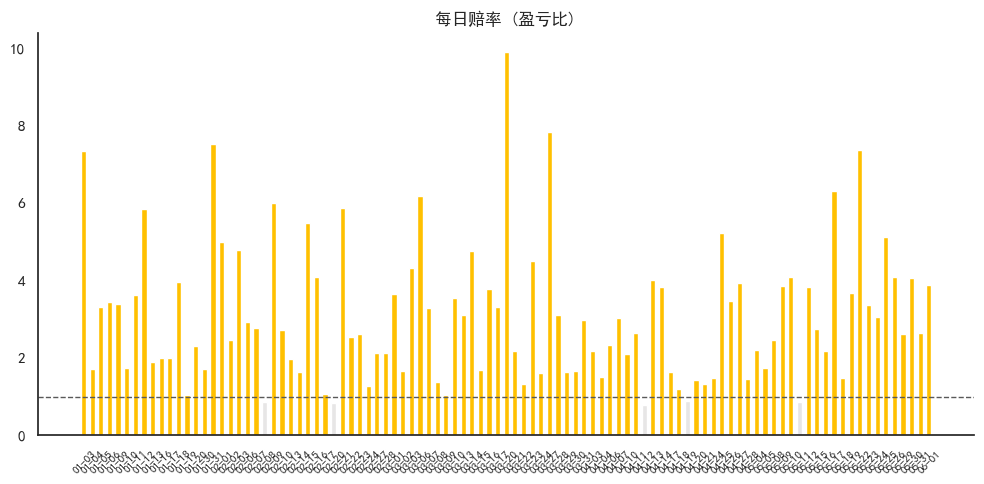

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import gridspec

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

def analyze_account_log(df):
    # 1. 预处理
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df['平仓时间'] = pd.to_datetime(df['平仓时间'])

    if df['收益率'].dtype == 'O':
        df['收益率'] = df['收益率'].str.replace('%', '').astype(float) / 100

    df['持仓分钟'] = (df['平仓时间'] - df.index).dt.total_seconds() / 60
    df['日期'] = df.index.date
    
    # 2. 每日统计
    daily = df.groupby('日期').agg(
        次数=('收益率', 'count'),
        平均时长=('持仓分钟', 'mean'),
        平均盈利=('收益率', lambda x: x[x > 0].mean() if (x > 0).any() else 0),
        平均亏损=('收益率', lambda x: abs(x[x <= 0].mean()) if (x <= 0).any() else 0.0001)
    )
    daily['胜率'] = df.groupby('日期')['收益率'].apply(lambda x: (x > 0).sum() / len(x))
    daily['赔率'] = daily['平均盈利'] / daily['平均亏损']
    
    # 3. 总体摘要
    summary = {
        '总胜率': (df['收益率'] > 0).sum() / len(df),
        '总赔率': df[df['收益率'] > 0]['收益率'].mean() / abs(df[df['收益率'] <= 0]['收益率'].mean()),
        '总天数': len(daily),
        '日均频率': daily['次数'].mean()
    }
    return daily, summary

def visualize_refined(daily, summary):
    sns.set_theme(style="white", font="SimHei")
    # 精简日期
    dates = [d.strftime('%m-%d') for d in daily.index]
    
    C_BLUE, C_SOFT_RED, C_GREEN, C_GOLD, C_GRAY = "#5B9BD5", "#FF8C8C", "#70AD47", "#FFC000", "#E7E6E6"

    # 图 1: 活跃度
    fig1, ax1 = plt.subplots(figsize=(10, 5))
    sns.barplot(x=dates, y=daily['次数'], color=C_BLUE, alpha=0.8, ax=ax1)
    ax1_t = ax1.twinx()
    ax1_t.plot(dates, daily['平均时长'], color=C_SOFT_RED, marker='o', linewidth=1.5, markersize=4)
    ax1.set_title("交易活跃度：次数与时长")
    ax1.tick_params(axis='x', rotation=45, labelsize=8) # 旋转并缩小字体
    sns.despine(top=True, right=False)
    plt.tight_layout()
    plt.show()

    # 图 2: 胜率
    fig2, ax2 = plt.subplots(figsize=(10, 5))
    ax2.plot(dates, daily['胜率'], marker='o', color=C_GREEN, linewidth=1.5, mfc='white', markersize=4)
    ax2.axhline(y=summary['总胜率'], color=C_SOFT_RED, linestyle=':', label=f"均值: {summary['总胜率']:.1%}")
    ax2.fill_between(dates, daily['胜率'], color=C_GREEN, alpha=0.15)
    ax2.set_title("交易胜率稳定性")
    ax2.set_ylim(0, 1.1)
    ax2.tick_params(axis='x', rotation=45, labelsize=8)
    ax2.legend(frameon=False)
    sns.despine()
    plt.tight_layout()
    plt.show()

    # 图 3: 赔率
    fig3, ax3 = plt.subplots(figsize=(10, 5))
    clrs = [C_GOLD if x >= 1 else C_GRAY for x in daily['赔率']]
    ax3.bar(dates, daily['赔率'], color=clrs, width=0.6)
    ax3.axhline(y=1, color="#595959", linewidth=1, linestyle='--')
    ax3.set_title("每日赔率 (盈亏比)")
    ax3.tick_params(axis='x', rotation=45, labelsize=8)
    sns.despine()
    plt.tight_layout()
    plt.show()

# --- 使用示例 ---
if __name__ == "__main__":
   
    # 读取数据
    df = pd.read_excel("Database\Account_log.xlsx", index_col=0)
    
    # 执行分析
    daily_results, total_summary = analyze_account_log(df)
    
    # 打印部分分析结果
    print("统计结果:")
    print(total_summary)
    
    # 执行可视化
    visualize_refined(daily_results, total_summary)